# Idea

We all know the value of a company that hold large amount of Bitcoin (e.g. MicroStrategy) should be subject to movement in Bitcoin price.

Given this assumption, can we use Bitcoin as a 'predictor' of the 'fair-price' of such stock?

In [27]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
company = 'MSTR'
crypto = 'BTC-USD'
tickers = [company,crypto]
df = yf.download(tickers,period = "7d", interval = "1m")['Close']
df.dropna(inplace=True)

[*********************100%***********************]  2 of 2 completed


Is there really a correlation?

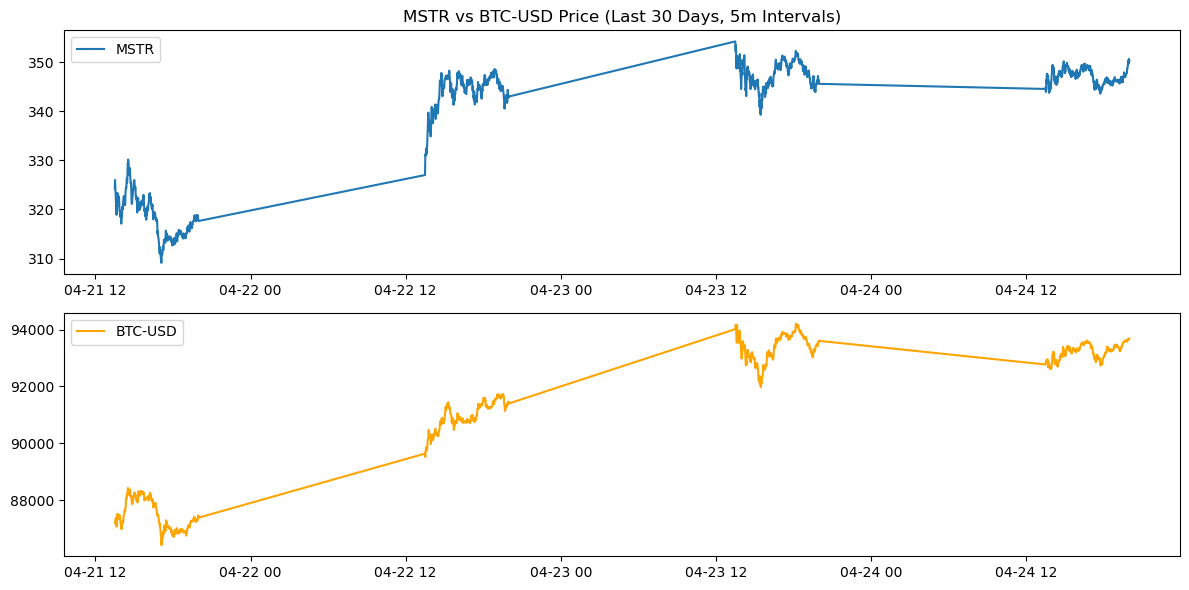

In [88]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title(f'{company} vs BTC-USD Price (Last 30 Days, 5m Intervals)')
plt.plot(df[company], label=company)
plt.legend()
plt.subplot(212)
plt.plot(df[crypto], label=crypto, color='orange')
plt.legend()
plt.tight_layout()
plt.show()

In [122]:
def granger_lag_significance(df, company, crypto, max_lag=180):
    import warnings
    warnings.filterwarnings("ignore", message="verbose is deprecated since functions should not print results")
    
    stationary_df = pd.DataFrame({
        company: df[company].diff().dropna(),
        crypto: df[crypto].diff().dropna()
    })
    stationary_df.dropna(inplace=True)
    
    results = {}
    for lag in range(1, max_lag+1):
        test_df = stationary_df[[company, crypto]].copy()
        test_result = grangercausalitytests(test_df, maxlag=lag, verbose=False)
        results[lag] = test_result[lag][0]['ssr_ftest'][1]
    
    lags = list(results.keys())
    p_values = list(results.values())
    
    plt.figure(figsize=(12, 6))
    plt.plot(lags, p_values, marker='o')
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance level (0.05)')
    plt.fill_between(lags, 0, 0.05, color='red', alpha=0.1)
    plt.xlabel('Lag (minutes)')
    plt.ylabel('p-value')
    plt.yscale('log')
    plt.title(f'Granger Causality p-values: {crypto} → {company}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Find significant lags
    significant_lags = [lag for lag, p in results.items() if p < 0.05]
    min_significant = min(significant_lags) if significant_lags else None
    
    if significant_lags:
        print(f"Significant lags: {significant_lags}")
        print(f"Earliest significant lag: {min_significant} minutes")
    else:
        print("No significant causal relationship found at any lag")
    
    plt.tight_layout()
    plt.show()
    
    return results

Significant lags: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Earliest significant lag: 12 minutes


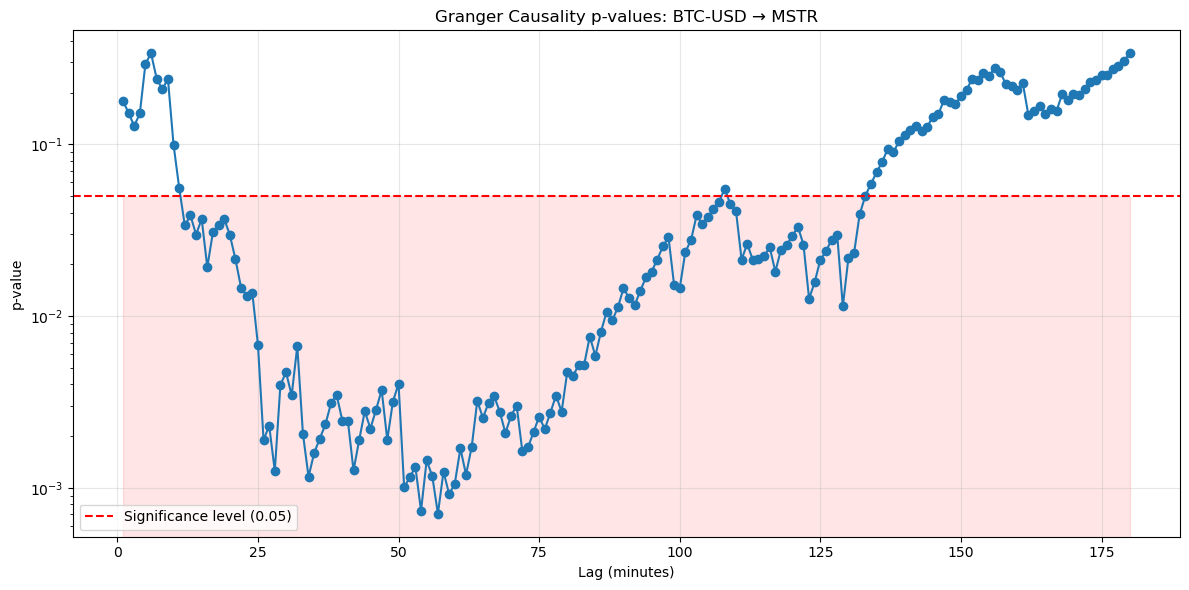

In [124]:
results = granger_lag_significance(df, company, crypto)

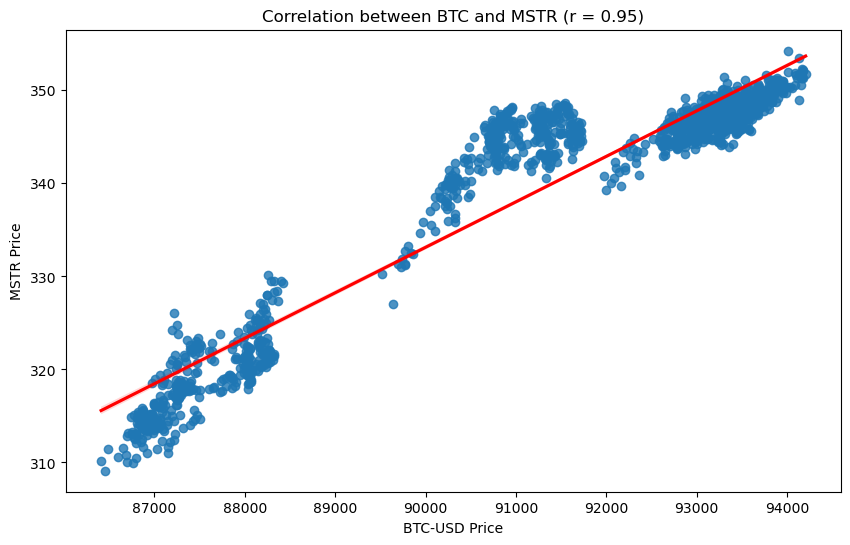

In [125]:
plt.figure(figsize=(10, 6))
sns.regplot(x=df[crypto], y=df[company], line_kws={"color":"red"})
plt.title(f'Correlation between BTC and {company} (r = {df.corr().iloc[0,1]:.2f})')
plt.xlabel(f'{crypto} Price')
plt.ylabel(f'{company} Price')
plt.show()